In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: Tesla V100-DGXS-32GB


In [3]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
"""
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
"""

'\ndef set_seed(seed_value=42):\n    random.seed(seed_value)\n    np.random.seed(seed_value)\n    torch.manual_seed(seed_value)\n    torch.cuda.manual_seed_all(seed_value)\n'

In [4]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

I0809 19:11:40.941958 140636640298752 file_utils.py:41] PyTorch version 1.2.0 available.


In [5]:
df = pd.read_csv('it-annotation-1000-revenue.csv')

In [6]:
df.head()

,No.,Data,Label
0,1,"Regarding our second action, the strategic rev...",neither
1,2,Depreciation and amortization decreased $10.5 ...,neither
2,3,Information Technology,neither
3,4,"Our competitors compete with us in many ways, ...",revenue
4,5,"In particular, depreciation and amortization c...",neither


In [7]:
df = df[['Data','Label']]

In [8]:
df['Label'].value_counts()

neither    935
revenue     65
Name: Label, dtype: int64

In [9]:
encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['encode_cat'] = df['Label'].apply(lambda x: encode_cat(x))

In [10]:
df.columns = ['STATEMENT', 'LABEL', 'ENCODE_CAT']
df.head()

,STATEMENT,LABEL,ENCODE_CAT
0,"Regarding our second action, the strategic rev...",neither,0
1,Depreciation and amortization decreased $10.5 ...,neither,0
2,Information Technology,neither,0
3,"Our competitors compete with us in many ways, ...",revenue,1
4,"In particular, depreciation and amortization c...",neither,0


In [11]:
label_dict = {0: "neither", 1: "revenue"}

In [12]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 5
LEARNING_RATE = 3e-05

# Specify hidden size of BERT, hidden size of our classifier, and number of labels
D_in, H, D_out = 768, 50, 2
dropout_rate = 0.3
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

I0809 19:11:42.120397 140636640298752 tokenization_utils.py:501] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [13]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.STATEMENT[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [14]:
# Creating the dataset and dataloader for the neural network

train_size = 0.75
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (1000, 3)
TRAIN Dataset: (750, 3)
TEST Dataset: (250, 3)


In [15]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params, drop_last=True)
testing_loader = DataLoader(testing_set, **test_params, drop_last=True)

In [16]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Linear(D_in, H)        
        self.l3 = torch.nn.Dropout(dropout_rate)
        self.l4 = torch.nn.Linear(H, D_out)
        
    def forward(self, ids, mask):
        output_1 = self.l1(ids, mask)
        output_2 = self.l2(output_1[0][:,0,:])
        output_3 = self.l3(output_2)
        output = self.l4(output_3)
        return output

### Initialise model

In [17]:
model = BERTClass()
# model.load_state_dict(torch.load('it-strategy-classification_revenue_01.pt')) # if loading from saved state
model.to(device)

I0809 19:11:43.095481 140636640298752 configuration_utils.py:256] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I0809 19:11:43.097028 140636640298752 configuration_utils.py:292] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings"

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [18]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [19]:
# Defining the training function 
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        # print(outputs)
        optimizer.zero_grad()
        loss = loss_function(outputs, targets)
        if _%5000==0:
            print("Epoch: {}".format(epoch),", Loss:  {}".format(loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [20]:
import time

start = time.time()

for epoch in range(EPOCHS):
    train(epoch)

end = time.time()
print(end - start)

Epoch: 0 , Loss:  0.768957257270813
Epoch: 1 , Loss:  0.08177986741065979
Epoch: 2 , Loss:  0.0352206826210022
Epoch: 3 , Loss:  0.0045204758644104
Epoch: 4 , Loss:  0.0058994293212890625
343.338045835495


In [21]:
def bert_predict(model, testing_loader):
    model.eval()
    fin_targets = []; fin_outputs_prob = [] 
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs_prob.extend(torch.nn.functional.softmax(outputs).cpu().detach().numpy().tolist())
    return fin_targets, fin_outputs_prob

In [22]:
targets, probs = bert_predict(model, testing_loader)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [31]:
# Get predictions from the probabilities
threshold = 0.4
probs = np.array(probs)
preds = np.where(probs[:, 1] > threshold, 1, 0)

print(metrics.classification_report(targets, preds,labels=[1,0]))
print("Confusion Matrix:", '\n',metrics.confusion_matrix(targets,preds,labels=[1,0]))

              precision    recall  f1-score   support

           1       0.86      0.30      0.44        20
           0       0.94      1.00      0.97       230

    accuracy                           0.94       250
   macro avg       0.90      0.65      0.71       250
weighted avg       0.94      0.94      0.93       250

Confusion Matrix: 
 [[  6  14]
 [  1 229]]


In [24]:
fpr, tpr, thresholds = metrics.roc_curve(targets, probs[:,1],pos_label=1)

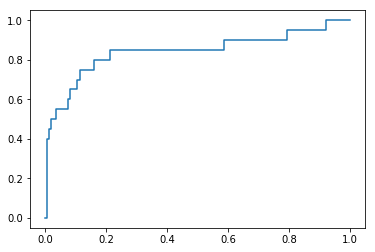

In [27]:
import matplotlib.pyplot as plt
plt.plot(fpr,tpr)

In [26]:
# torch.save(model.state_dict(), 'it-strategy-classification_revenue_01.pt')